# Microcanonical Monte Carlo

## setup

In [1]:
include("../src/ising.jl")
using CairoMakie
import LsqFit as lsq
using JLD2
using ProgressMeter
import StatsBase as sb

In [2]:
function creutz_step(grid::Array{Int,3}; E_max::Float64=10*J, E_deamon::Float64=0.0, J::Float64=1.0, B::Float64=0.0)
    N1, N2, N3 = size(grid)
    i, j, k = rand(1:N1), rand(1:N2), rand(1:N3)
    dE = energy_diff(grid, (i, j, k), J=J, B=B)
    dM = 2*grid[i, j, k]
    if dE <= 0 || E_max >= E_deamon - dE >= 0
        grid[i, j, k] *= -1
        E_deamon -= dE
    else 
        dE = 0
        dM = 0
    end

    if E_deamon < 0
        E_deamon = 0
    elseif E_deamon > E_max
        E_deamon = E_max
    end
    
    return grid, E_deamon, dE, dM
end

creutz_step (generic function with 1 method)

In [3]:
function creutz_simulate_to_eq(; grid_size::Int=10, E_max::Float64=2.0*J, E_deamon::Float64=E_max, J::Float64=1.0, B::Float64=0.0, N::Int=10_000_000, initial_up_prob::Float64=0.5)
    grid = create_grid(grid_size, up_prob=initial_up_prob)
    E_eq = -length(grid) * 3
    energies, magnetisations, daemon_energies = Float64[], Float64[], Float64[]
    push!(energies, energy(grid, J, B))
    push!(magnetisations, magnetisation(grid)/length(grid))
    for i in 1:N
        grid, E_deamon,  dE, dM = creutz_step(grid,E_max=E_max, E_deamon=E_deamon, J=J, B=B)
        push!(energies, energies[end] + dE)
        push!(magnetisations, magnetisations[end] + dM/length(grid))
        push!(daemon_energies, E_deamon)
        if energies[end] == E_eq
            break
        end
    end
    return daemon_energies, energies, magnetisations
end

creutz_simulate_to_eq (generic function with 1 method)

## Simulate

### test with single energy level

In [4]:
E_max = 20.0
dmn, nrg, mag = creutz_simulate_to_eq(E_max=E_max)

([20.0, 20.0, 20.0, 16.0, 16.0, 20.0, 16.0, 20.0, 20.0, 16.0  …  8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 20.0, 20.0], [-100.0, -100.0, -100.0, -100.0, -96.0, -96.0, -104.0, -100.0, -104.0, -108.0  …  -2976.0, -2976.0, -2976.0, -2976.0, -2976.0, -2976.0, -2976.0, -2976.0, -2988.0, -3000.0], [4.0e-5, 0.00204, 0.00404, 0.00604, 0.00404, 0.00604, 0.00404, 0.00604, 0.00804, 0.01004  …  -0.9559600000000008, -0.9559600000000008, -0.9559600000000008, -0.9559600000000008, -0.9559600000000008, -0.9559600000000008, -0.9559600000000008, -0.9559600000000008, -0.9579600000000008, -0.9599600000000008])

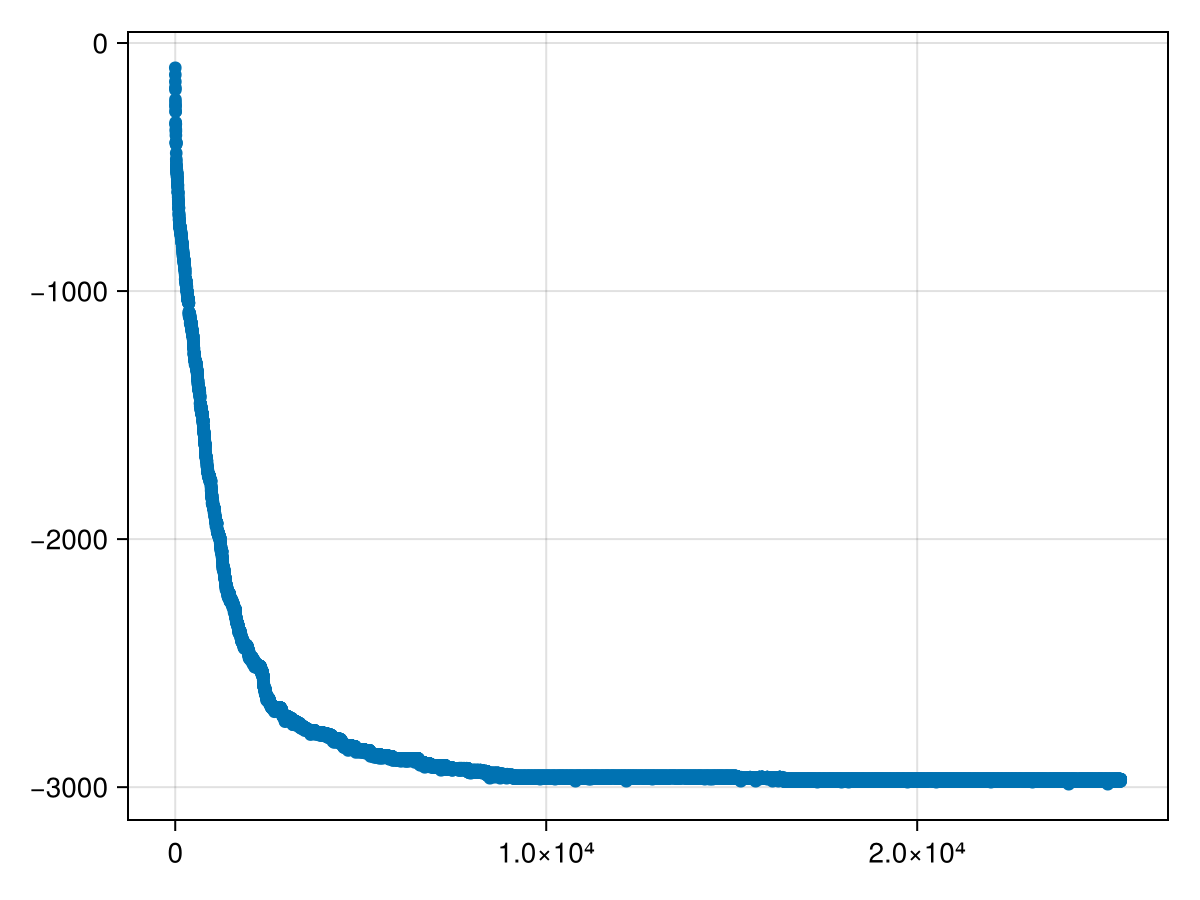

In [5]:
fig = Figure()
ax = Axis(fig[1, 1])
# only plot every 100th point
plot!(ax,nrg[1:100:end])
fig

In [6]:
linfit(x, p) = x .* p[1] .+ p[2]

linfit (generic function with 1 method)

T= 2.805873552121116


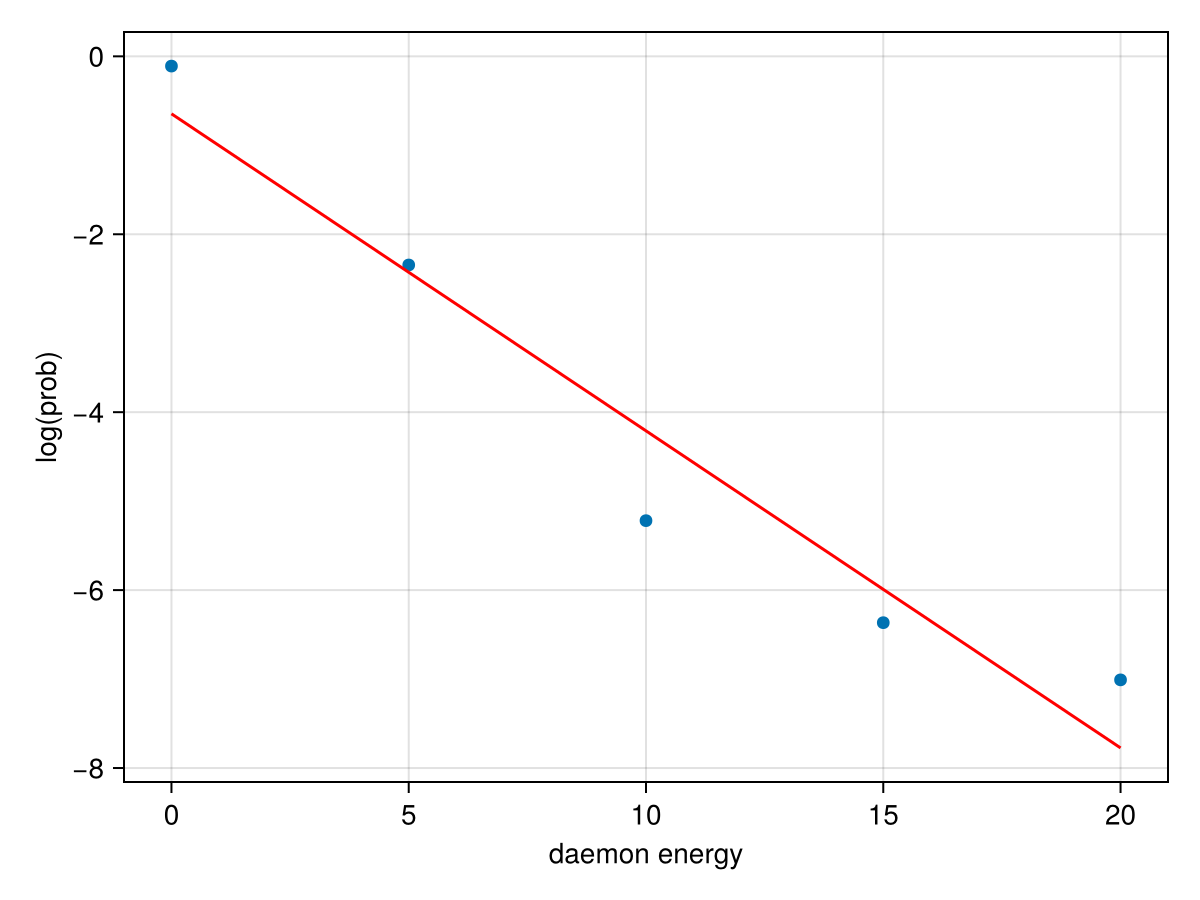

In [7]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="daemon energy", ylabel="log(prob)")
dmn_hist = sb.fit(sb.Histogram, dmn, nbins=floor(E_max/4)+1)
dmn_val = dmn_hist.edges[1][1:end-1]
dmn_prob = dmn_hist.weights ./ sum(dmn_hist.weights)

plot!(ax, dmn_val, log.(dmn_prob))

fit = lsq.curve_fit(linfit, dmn_val, log.(dmn_prob), [1.0, 1.0])
lines!(ax, dmn_val, linfit(dmn_val, fit.param), color=:red)

println("T= ", -1/fit.param[1])

# hist!(ax, dmn)
fig

### test with multiple energy levels

In [8]:
len = 14
E_Start = 20.0
E_End = 85.0
daemon_energies, energies, magnetisations = Vector{Vector{Float64}}(undef, len), Vector{Vector{Float64}}(undef, len), Vector{Vector{Float64}}(undef, len)
max_energies = Vector{Float64}(undef, len)
Threads.@threads for (i, e) in collect(enumerate(range(E_Start,E_End, length=len)))
    e = round(e, digits=1)
    dmn, nrg, mag = creutz_simulate_to_eq(E_max=e)
    daemon_energies[i] = dmn
    energies[i] = nrg
    magnetisations[i] = mag
    max_energies[i] = e
end
max_energies

14-element Vector{Float64}:
 20.0
 25.0
 30.0
 35.0
 40.0
 45.0
 50.0
 55.0
 60.0
 65.0
 70.0
 75.0
 80.0
 85.0

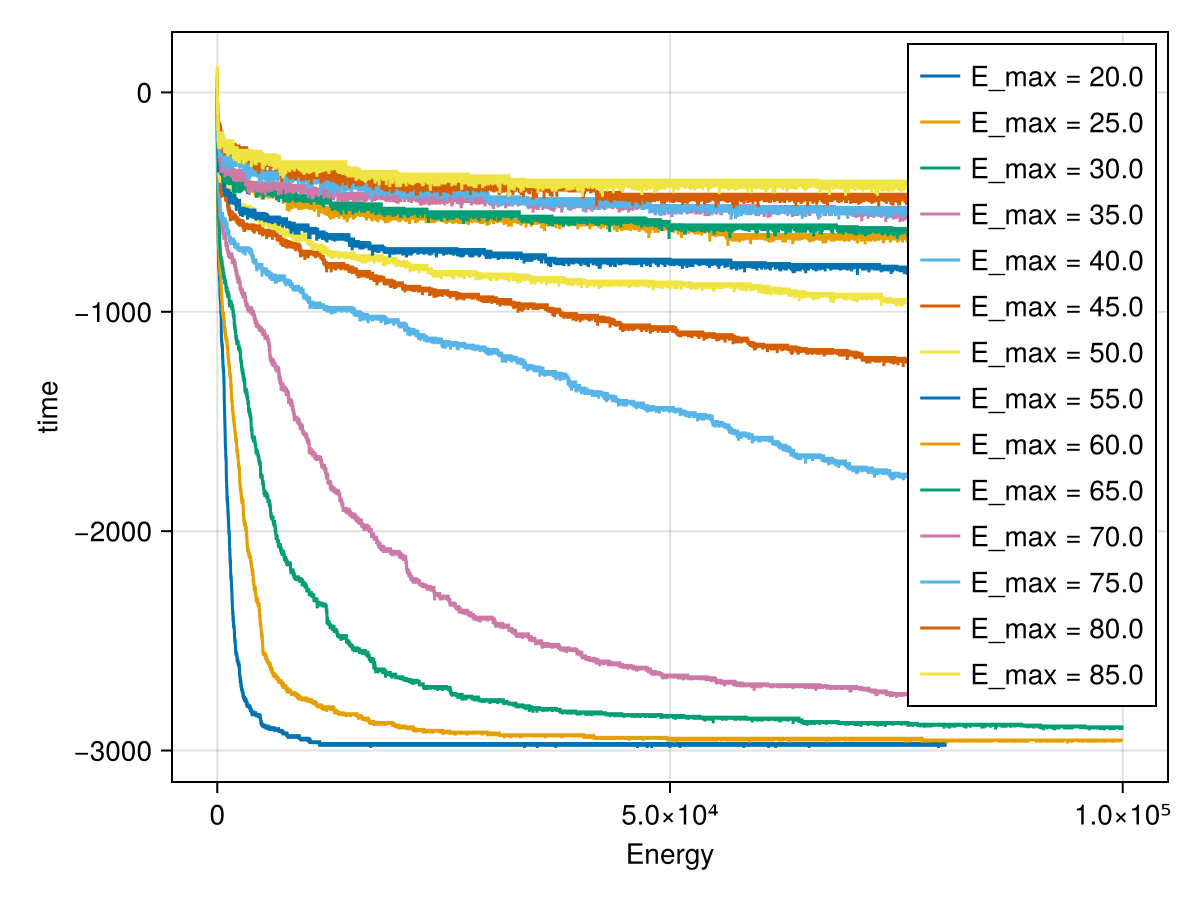

In [9]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Energy", ylabel="time")
for (nrg, E_max) in zip(energies, max_energies)
    lines!(ax,nrg[1:100:end], label="E_max = $E_max")
end
axislegend(ax)
fig

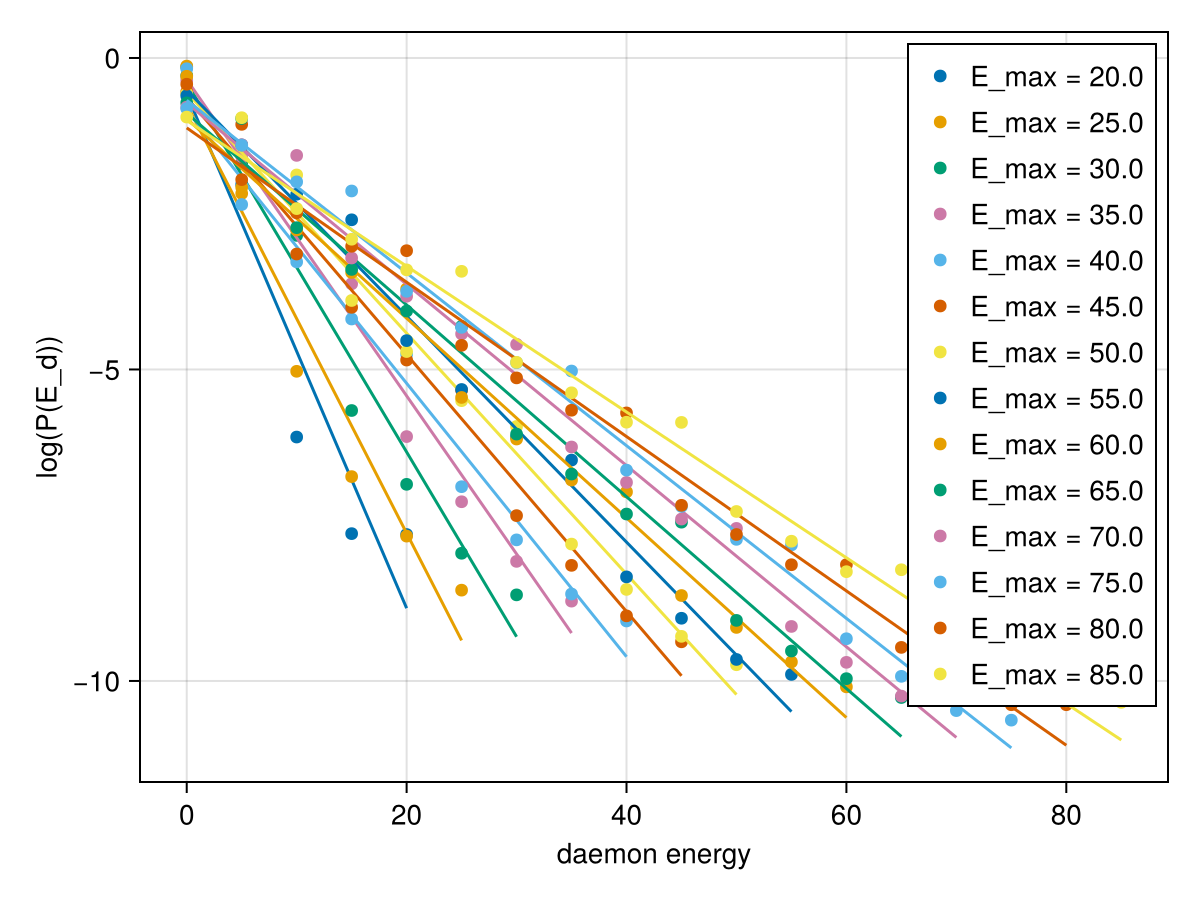

In [10]:
fig = Figure()
temps = Float64[]
ax = Axis(fig[1, 1], xlabel="daemon energy", ylabel="log(P(E_d))")
for (dmn, E_max) in zip(daemon_energies, max_energies)
    # hist!(ax, dmn, label="E_max = $E_max")
    dmn_hist = sb.fit(sb.Histogram, dmn, nbins=floor(E_max/4)+1)
    dmn_val = dmn_hist.edges[1][1:end-1]
    dmn_prob = dmn_hist.weights/sum(dmn_hist.weights)
    plot!(ax, dmn_val, log.(dmn_prob), label="E_max = $E_max")

    fit = lsq.curve_fit(linfit, dmn_val, log.(dmn_prob), [1.0, 1.0])
    lines!(ax, dmn_val, linfit(dmn_val, fit.param))
    push!(temps, -1/fit.param[1])

    # println(dmn_hist.weights)
end
axislegend(ax)
fig

T(E_max) = 0.09043960391789804 * E_max + 0.6931713808291651


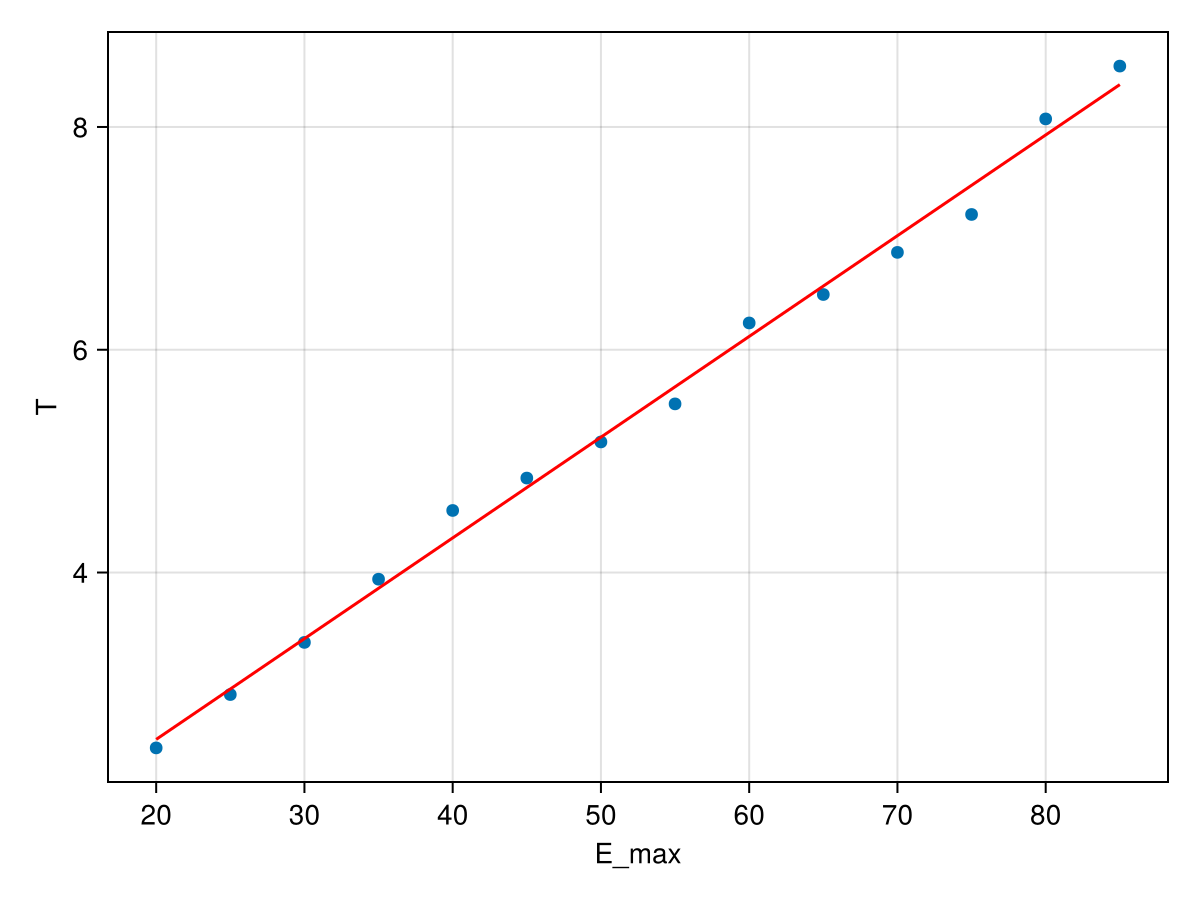

In [11]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="E_max", ylabel="T")
plot!(ax,max_energies, temps)

fit = lsq.curve_fit(linfit, max_energies, temps, [1.0, 1.0])
lines!(ax, max_energies, linfit(max_energies, fit.param), color=:red)

println("T(E_max) = ", fit.param[1], " * E_max + ", fit.param[2])

fig

In [12]:
eq_energies, eq_mags = Float64[], Float64[]
for (nrg, mag) in zip(energies, magnetisations)
    push!(eq_energies, mean(nrg[end-100:end]))
    push!(eq_mags, mean(mag[end-100:end]))
end

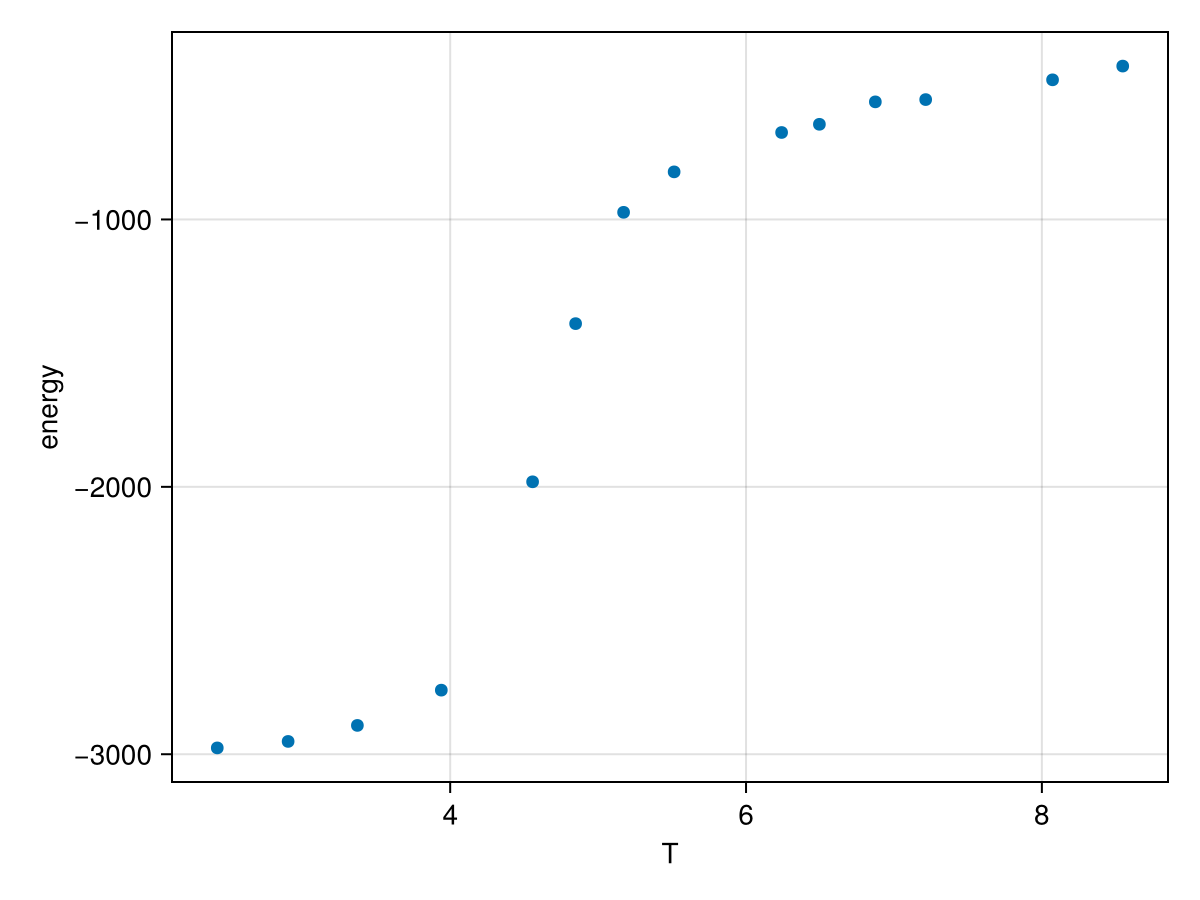

In [13]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="energy")
plot!(ax,temps, eq_energies)
fig

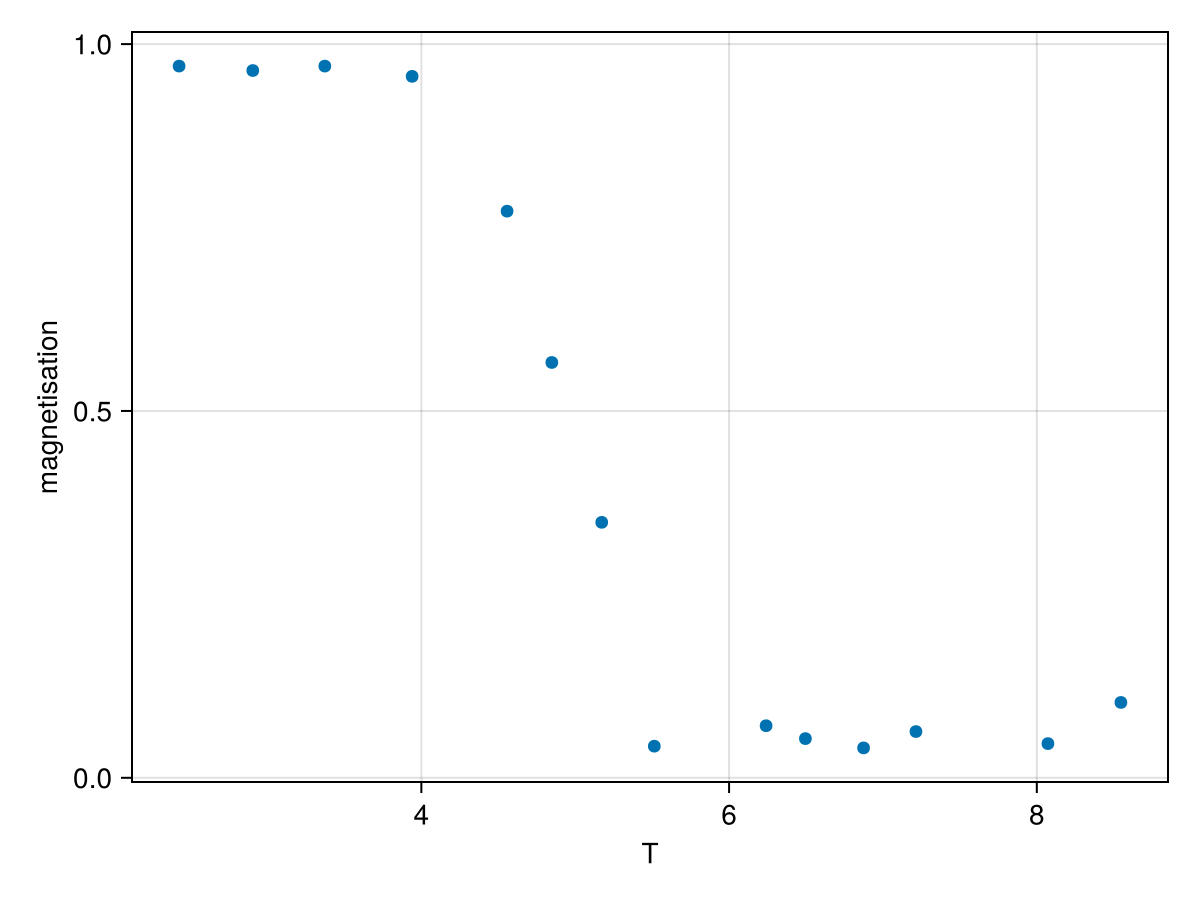

In [14]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="magnetisation")
plot!(ax,temps, abs.(eq_mags))
fig

### Vary system size

In [15]:
function creutz_energy_sweep(; grid_size::Int=10, E_Start::Float64=20.0, E_End::Float64=85.0, E_Steps::Int=14, J::Float64=1.0, B::Float64=0.0, N::Int=10_000_000, initial_up_prob::Float64=0.5)
    daemon_energies, energies, magnetisations = Vector{Vector{Float64}}(undef, E_Steps), Vector{Vector{Float64}}(undef, E_Steps), Vector{Vector{Float64}}(undef, E_Steps)
    max_energies = Vector{Float64}(undef, E_Steps)
    Threads.@threads for (i, e) in collect(enumerate(range(E_Start,E_End, length=E_Steps)))
        e = round(e, digits=1)
        dmn, nrg, mag = creutz_simulate_to_eq(grid_size=grid_size, E_max=e, J=J, B=B, N=N, initial_up_prob=initial_up_prob)
        daemon_energies[i] = dmn
        energies[i] = nrg
        magnetisations[i] = mag
        max_energies[i] = e
    end

    temps = Vector{Float64}(undef, E_Steps)

    Threads.@threads for (iE, (dmn, E_max)) in collect(enumerate(zip(daemon_energies, max_energies)))
        dmn_hist = sb.fit(sb.Histogram, dmn, nbins=floor(E_max/4)+1)
        dmn_val = dmn_hist.edges[1][1:end-1]
        dmn_prob = dmn_hist.weights/sum(dmn_hist.weights)

        fit = lsq.curve_fit(linfit, dmn_val, log.(dmn_prob), [1.0, 1.0])

        temps[iE] = -1/fit.param[1]
    end

    eq_energies, eq_mags = Float64[], Float64[]
    for (nrg, mag) in zip(energies, magnetisations)
        push!(eq_energies, mean(nrg[end-100:end]))
        push!(eq_mags, mean(mag[end-100:end]))
    end
    return max_energies, temps, eq_energies, eq_mags

end

creutz_energy_sweep (generic function with 1 method)

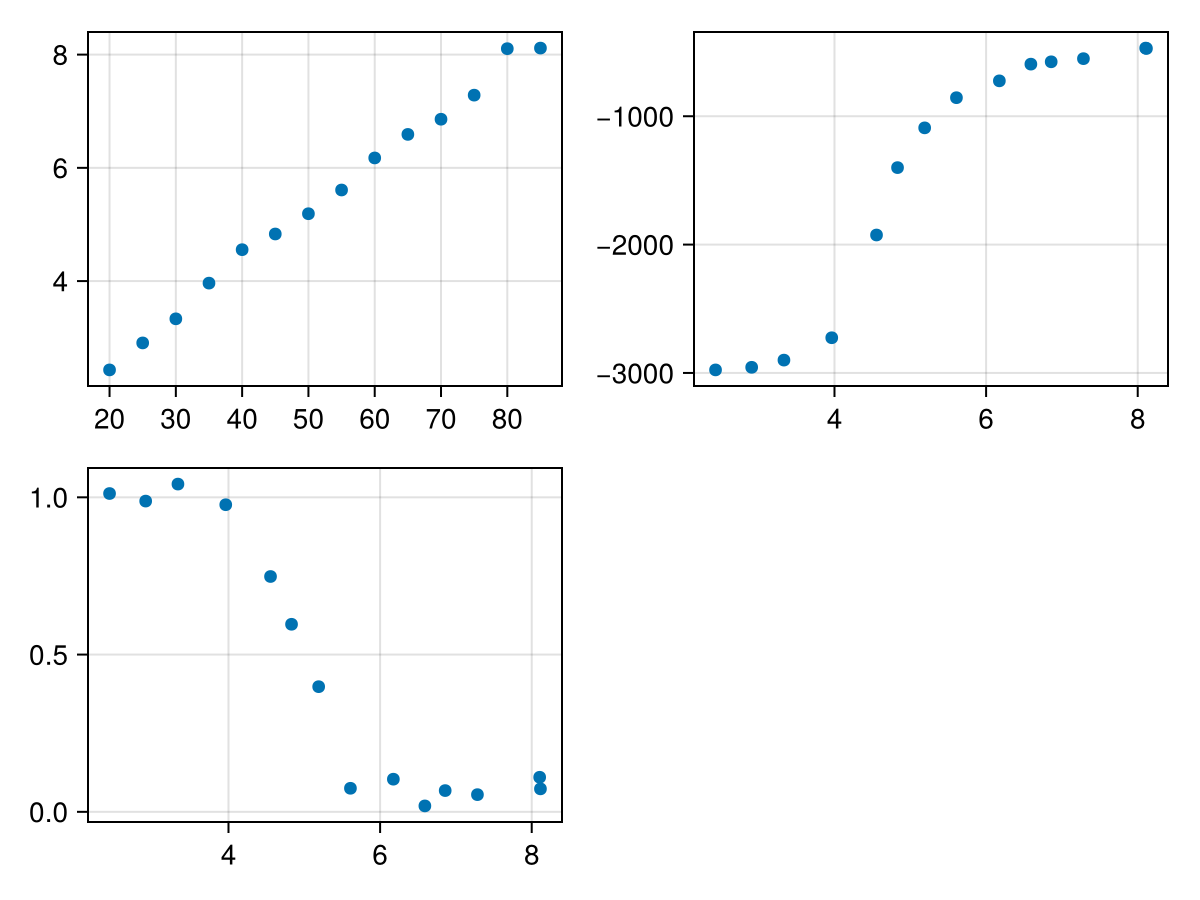

In [16]:
me, t, eqe, eqm = creutz_energy_sweep()
fig = Figure()
plot(fig[1, 1],me, t)
plot(fig[1, 2],t, eqe)
plot(fig[2, 1],t, abs.(eqm))
fig

In [17]:
grid_sizes = [6, 8, 10, 12, 14, 18, 22]
max_energies, temps, eq_energies, eq_mags = Vector{Vector{Float64}}(undef, length(grid_sizes)), Vector{Vector{Float64}}(undef, length(grid_sizes)), Vector{Vector{Float64}}(undef, length(grid_sizes)), Vector{Vector{Float64}}(undef, length(grid_sizes))
Threads.@threads for (i, grid_size) in collect(enumerate(grid_sizes))
    max_energies[i], temps[i], eq_energies[i], eq_mags[i] = creutz_energy_sweep(grid_size=grid_size)
end

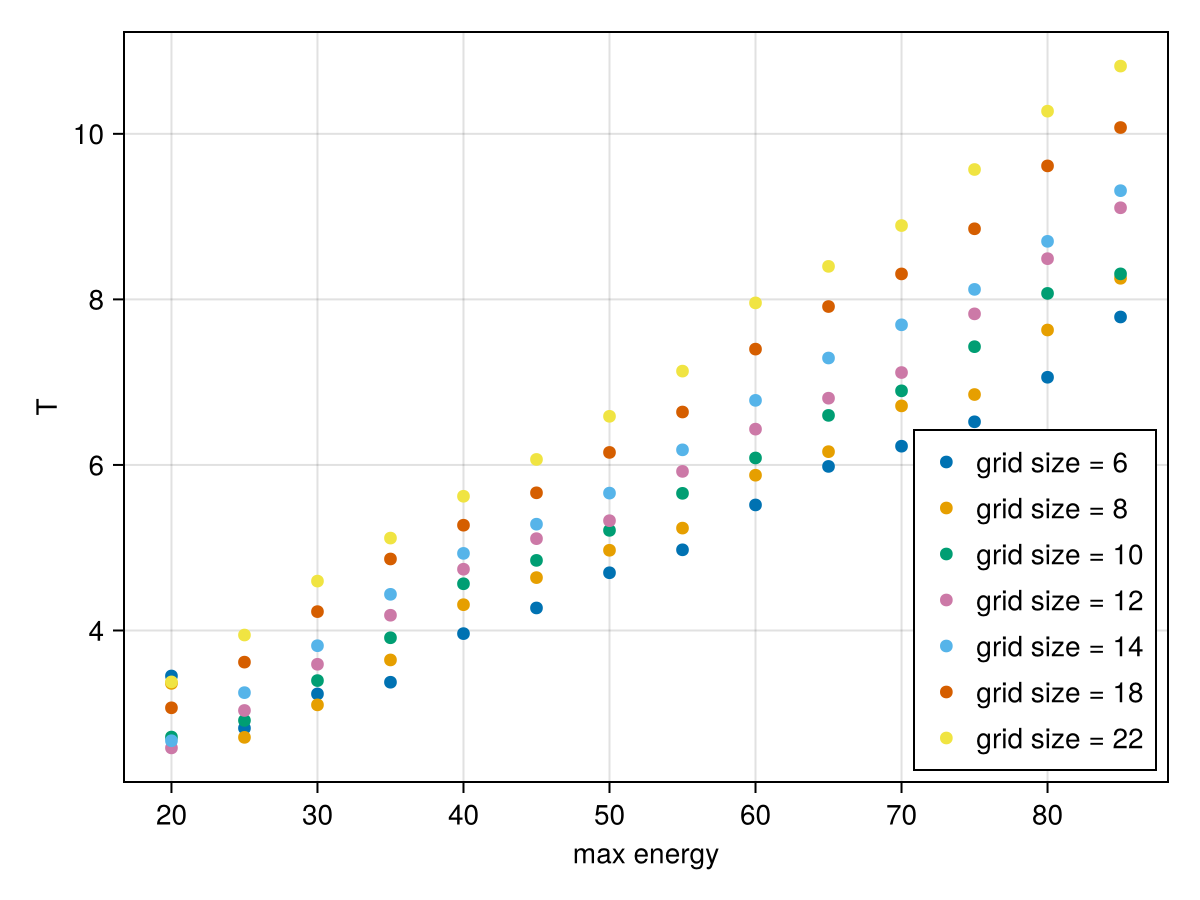

In [18]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="max energy", ylabel="T")
for (t, me, gs) in zip(temps, max_energies, grid_sizes)
    plot!(ax, me, t, label="grid size = $gs")
end
axislegend(ax, position=:rb)
fig

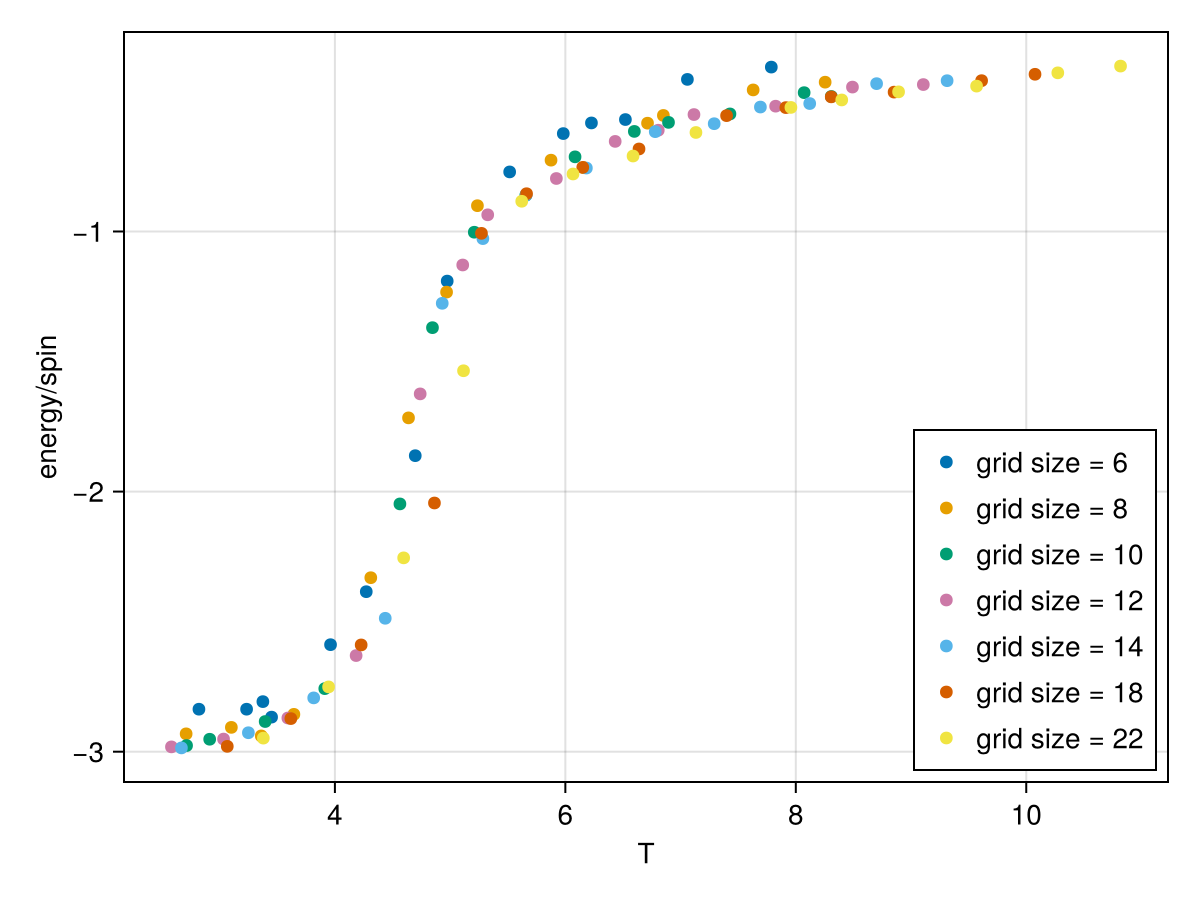

In [21]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="energy/spin")
for (t, eqe, grid_size) in zip(temps, eq_energies, grid_sizes)
    plot!(ax,t, eqe./grid_size^3, label="grid size = $grid_size")
end
axislegend(ax, position=:rb)
fig

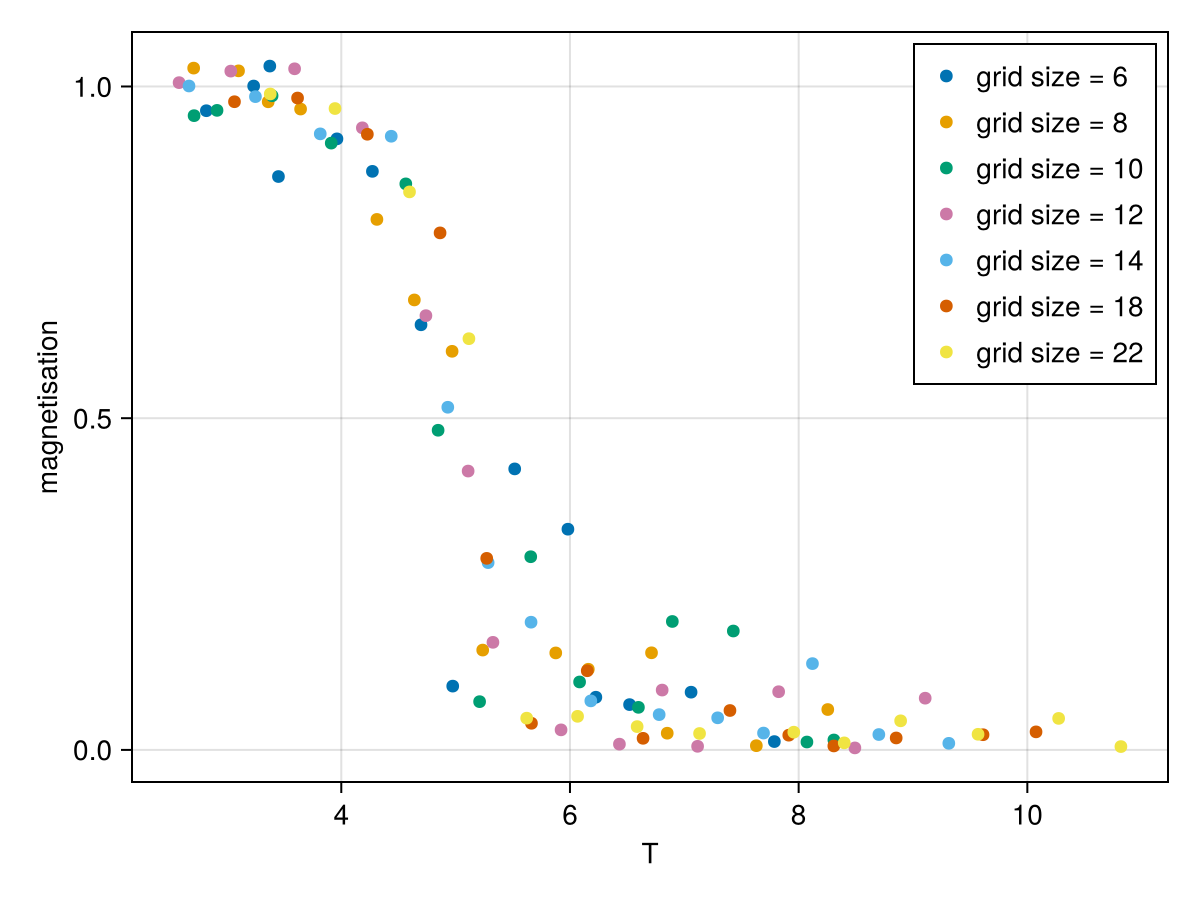

In [20]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="T", ylabel="magnetisation")
for (t, eqm, grid_size) in zip(temps, eq_mags, grid_sizes)
    plot!(ax,t, abs.(eqm), label="grid size = $grid_size")
end
axislegend(ax, position=:rt)
fig